<a href="https://colab.research.google.com/github/ashishar/Perimeter-Institute-Mini-Course-Quantum-2024/blob/master/QML_Lecture_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install pennylane

In [ ]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

In [ ]:
X = np.linspace(0,2*np.pi,10)
X.requires_grad = False
X_test = np.linspace(0.2,2*np.pi+0.2,10)

(<Figure size 500x200 with 1 Axes>, <Axes: >)

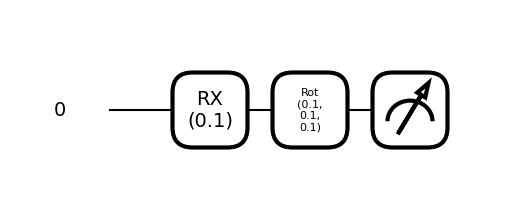

In [ ]:
dev = qml.device('default.qubit', wires = 1)

@qml.qnode(dev)
def quantum_model(x, params):
  qml.RX(x, wires = 0)
  qml.Rot(*params, wires = 0)

  return qml.expval(qml.PauliZ(wires = 0))

qml.draw_mpl(quantum_model, decimals=1)(0.1,[0.1,0.1,0.1])

In [ ]:
def loss(Y,predictions):
    total_loss=0
    for y,p in zip(Y,predictions):
        total_loss += (y-p)**2
    return total_loss

In [ ]:
def cost(X,params):
    predictions = [quantum_model(x,params) for x in X]
    Y = np.sin(X)
    cost = loss(Y,predictions)
    return cost

In [ ]:
# Step 6 - Train your circuit

# Steps 6.1 - Choose an optimizer and a step size
opt = qml.GradientDescentOptimizer(stepsize=0.1)

# Step 6.2 Make an initial guess for the parameters and set them as trainable
params = np.array([0.1,0.1,0.1],requires_grad=True)

# Step 6.2 - Iterate over a number of defined steps
for i in range(100):
    data_and_params,prev_cost = opt.step_and_cost(cost,X,params)
    params = data_and_params[1]
    if i%10==0:
        print(f'Step: {i},Cost: {cost(X,params)}')

Step: 0,Cost: 9.932888918479078
Step: 10,Cost: 0.015055887192330916
Step: 20,Cost: 0.0034863357216068525
Step: 30,Cost: 0.0015271569906079433
Step: 40,Cost: 0.0008553695091742079
Step: 50,Cost: 0.000546727803367964
Step: 60,Cost: 0.0003795931092589439
Step: 70,Cost: 0.0002789505418953934
Step: 80,Cost: 0.0002136616660207514
Step: 90,Cost: 0.00016890254015881152


In [ ]:
params

tensor([-1.46519326,  1.57079633,  0.1       ], requires_grad=True)

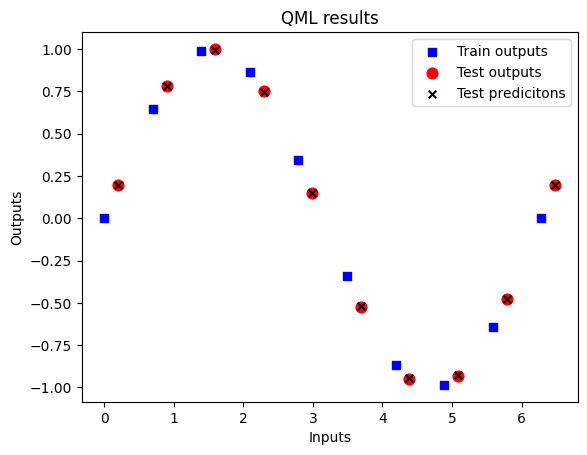

In [ ]:
# Step 6 - Test and graph your results!
test_predictions = []
for x_test in X_test:
    prediction = quantum_model(x_test,params)
    test_predictions.append(prediction)

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(X, np.sin(X), s=30, c='b', marker="s", label='Train outputs')
ax1.scatter(X_test,np.sin(X_test), s=60, c='r', marker="o", label='Test outputs')
ax1.scatter(X_test,test_predictions, s=30, c='k', marker="x", label='Test predicitons')
plt.xlabel("Inputs")
plt.ylabel("Outputs")
plt.title("QML results")

plt.legend(loc='upper right');
plt.show()

In [ ]:
dev = qml.device("default.qubit", wires = [0,1,2,3])

def layer(layer_weights):
    for wire in range(4):
        qml.Rot(*layer_weights[wire], wires=wire)

    for wires in ([0, 1], [1, 2], [2, 3], [3, 0]):
        qml.CNOT(wires)

@qml.qnode(dev)
def circuit(weights, x):
    qml.BasisState(x, wires=[0, 1, 2, 3])

    for layer_weights in weights:
        layer(layer_weights)

    return qml.expval(qml.PauliZ(0))


In [ ]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

In [ ]:
def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

In [ ]:
def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

In [ ]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

In [ ]:
data_train = np.array([[0, 0, 0, 1, 1],
[0, 0, 1, 0, 1],
[0, 1, 0, 0, 1],
[0, 1, 0, 1, 0],
[0, 1, 1, 0, 0],
[0, 1, 1, 1, 1],
[1, 0, 0, 0, 1],
[1, 0, 0, 1, 0],
[1, 0, 1, 1, 1],
[1, 1, 1, 1, 0]])

X = np.array(data_train[:, :-1])
Y = np.array(data_train[:, -1])
Y = Y * 2 - 1  # shift label from {0, 1} to {-1, 1}

for x,y in zip(X, Y):
    print(f"x = {x}, y = {y}")

x = [0 0 0 1], y = 1
x = [0 0 1 0], y = 1
x = [0 1 0 0], y = 1
x = [0 1 0 1], y = -1
x = [0 1 1 0], y = -1
x = [0 1 1 1], y = 1
x = [1 0 0 0], y = 1
x = [1 0 0 1], y = -1
x = [1 0 1 1], y = 1
x = [1 1 1 1], y = -1


In [ ]:
np.random.seed(0)

num_qubits = 4
num_layers = 2
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print("Weights:", weights_init)
print("Bias: ", bias_init)

Weights: [[[ 0.01764052  0.00400157  0.00978738]
  [ 0.02240893  0.01867558 -0.00977278]
  [ 0.00950088 -0.00151357 -0.00103219]
  [ 0.00410599  0.00144044  0.01454274]]

 [[ 0.00761038  0.00121675  0.00443863]
  [ 0.00333674  0.01494079 -0.00205158]
  [ 0.00313068 -0.00854096 -0.0255299 ]
  [ 0.00653619  0.00864436 -0.00742165]]]
Bias:  0.0


In [ ]:
from pennylane.optimize import NesterovMomentumOptimizer
opt = NesterovMomentumOptimizer(0.5)
batch_size = 5

weights = weights_init
bias = bias_init
for it in range(100):

    # Update the weights by one optimizer step, using only a limited batch of data
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias = opt.step(cost, weights, bias, X=X_batch, Y=Y_batch)

    # Compute accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]

    current_cost = cost(weights, bias, X, Y)
    acc = accuracy(Y, predictions)

    print(f"Iter: {it+1:4d} | Cost: {current_cost:0.7f} | Accuracy: {acc:0.7f}")

Iter:    1 | Cost: 2.3147651 | Accuracy: 0.5000000
Iter:    2 | Cost: 1.9664866 | Accuracy: 0.5000000
Iter:    3 | Cost: 1.9208589 | Accuracy: 0.5000000
Iter:    4 | Cost: 2.6276126 | Accuracy: 0.5000000
Iter:    5 | Cost: 0.9323119 | Accuracy: 0.6000000
Iter:    6 | Cost: 1.1903549 | Accuracy: 0.5000000
Iter:    7 | Cost: 2.0508989 | Accuracy: 0.4000000
Iter:    8 | Cost: 1.1275531 | Accuracy: 0.6000000
Iter:    9 | Cost: 1.1659803 | Accuracy: 0.6000000
Iter:   10 | Cost: 1.1349618 | Accuracy: 0.6000000
Iter:   11 | Cost: 0.9994063 | Accuracy: 0.6000000
Iter:   12 | Cost: 1.0812559 | Accuracy: 0.6000000
Iter:   13 | Cost: 1.2863155 | Accuracy: 0.6000000
Iter:   14 | Cost: 2.2658259 | Accuracy: 0.4000000
Iter:   15 | Cost: 1.1323724 | Accuracy: 0.6000000
Iter:   16 | Cost: 1.3439737 | Accuracy: 0.8000000
Iter:   17 | Cost: 2.0076168 | Accuracy: 0.6000000
Iter:   18 | Cost: 1.2685760 | Accuracy: 0.5000000
Iter:   19 | Cost: 1.6762475 | Accuracy: 0.5000000
Iter:   20 | Cost: 1.1868237 | 

In [ ]:
data_test = np.array([[0, 0, 0, 0, 0],
[0, 0, 1, 1, 0],
[1, 0, 1, 0, 0],
[1, 1, 1, 0, 1],
[1, 1, 0, 0, 0],
[1, 1, 0, 1, 1]])
X_test = np.array(data_test[:, :-1])
Y_test = np.array(data_test[:, -1])
Y_test = Y_test * 2 - 1  # shift label from {0, 1} to {-1, 1}

predictions_test = [np.sign(variational_classifier(weights, bias, x)) for x in X_test]

for x,y,p in zip(X_test, Y_test, predictions_test):
    print(f"x = {x}, y = {y}, pred={p}")

acc_test = accuracy(Y_test, predictions_test)
print("Accuracy on unseen data:", acc_test)

x = [0 0 0 0], y = -1, pred=-1.0
x = [0 0 1 1], y = -1, pred=-1.0
x = [1 0 1 0], y = -1, pred=-1.0
x = [1 1 1 0], y = 1, pred=1.0
x = [1 1 0 0], y = -1, pred=-1.0
x = [1 1 0 1], y = 1, pred=1.0
Accuracy on unseen data: 1.0
